In [ ]:
import numpy as np 
import math
import glob

from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout,LSTM, Reshape, Bidirectional, TimeDistributed, Input, add
    



def ResNet_Block(input, block_id, filterNum):
    ''' Create a ResNet block
    Args:
        input: input tensor
        filterNum: number of output filters
    Returns: a keras tensor
    '''

    x = Conv2D(filterNum, (1, 1), name='conv_s'+str(block_id)+'_1x1', padding='same',
               kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(1e-5))(input)
    shortcut = BatchNormalization()(x)
    x = LeakyReLU(0.01)(shortcut)

    x = Conv2D(filterNum, (3, 3), name='conv'+str(block_id)+'_1', padding='same',
               kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv2D(filterNum, (3, 3), name='conv'+str(block_id)+'_2', padding='same',
               kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv2D(filterNum, (1, 1), name='conv_f'+str(block_id)+'_1x1', padding='same',
               kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)

    x = add([x, shortcut])
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((1, 4))(x)
    return x




def melody_ResNet():
    num_output = int(55 * 2 ** (math.log(8, 2)) + 2)
    input = Input(shape=(31, 513, 1))

    block_1 = ResNet_Block(input=input, block_id=1,
                             filterNum=64)
    block_4 = ResNet_Block(input=block_1, block_id=2,
                             filterNum=256)
    block_4 = Dropout(0.5)(block_4)

    numOutput_P = block_4.shape[2] * block_4.shape[3]
    output = Reshape((31, numOutput_P))(block_4)
    output = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))(output)
    output = TimeDistributed(Dense(num_output))(output)
    output = TimeDistributed(Activation("softmax", name='softmax'))(output)


    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
import librosa
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import os
import csv

pitch_dir = '/content/drive/MyDrive/ATML-project/MIR-1K/PitchLabel-1'
wav_file = "/content/drive/MyDrive/ATML-project/MIR-1K/Wavfile"


def onehotlabel(pitch_range):
    values = np.asarray(pitch_range)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
#     print(integer_encoded)

    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

def getonehot(y):    
    yhot = np.zeros((len(y),len(pitch_range)))
    for i in range(len(y)):
        idx,val = closest(pitch_range,y[i]) 
#         print(idx,val,y[i])
        yhot[i,:] = onehot_pitch_range[idx,:]
    return yhot

def closest(arr, K):  # arr is a vector
    idx = (np.abs(arr - K)).argmin() 
    return idx,arr[idx]

def spec_extraction(file_name, win_size,test=False):
    x_test = []
    y, sr = librosa.load(file_name, sr=8000)
    S = librosa.core.stft(y, n_fft=1024, hop_length=80, win_length=1024)
    x_spec = np.abs(S)
    x_spec = librosa.core.power_to_db(x_spec, ref=np.max)
    x_spec = x_spec.astype(np.float32)
    if test:
      gtv,gtf = get_pitch_test(file_name)
    else:
      gtv,gtf = get_pitch(file_name)
    num_frames = x_spec.shape[1]
    # for padding
    padNum = num_frames % win_size
    if padNum != 0:
        len_pad = win_size - padNum
        padding_feature = np.zeros(shape=(513, len_pad))
        x_spec = np.concatenate((x_spec, padding_feature), axis=1)
        num_frames = num_frames + len_pad
    gtf = np.append(gtf,np.zeros(np.shape(x_spec)[1]-len(gtf)))
    # to convert frequency from Hz to MIDI values
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    gtf_midi = getonehot(gtf_midi)
    y_test = []
    for j in range(0, num_frames, win_size):
        x_test_tmp = x_spec[:, range(j, j + win_size)].T
        x_test.append(x_test_tmp)
        y_test_tmp = gtf_midi[j:j + win_size,:]
        y_test.append(y_test_tmp)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    x_train_mean = np.load('/content/x_data_mean_total_31.npy')
    x_train_std = np.load('/content/x_data_std_total_31.npy')
    x_test = (x_test-x_train_mean)/(x_train_std+0.0001)
    x_test = x_test[:, :, :, np.newaxis]

    return gtv,y_test,x_test

# To load true labels for Training
def get_pitch(file):
  gtf = []
  gtv = []
  pathname = os.path.splitext(file)[0]
  filename = os.path.basename(pathname)
  ff = pitch_dir + '/' + filename + ' .csv'
  with open(ff,'r') as fin:
      reader = csv.reader(fin)
      for row in reader:
          gtv.append(float(row[0]))
          gtf.append(float(row[1]))
    
  return gtv,gtf  

# To load true labels for Evaluation
def get_pitch_test(file):
  gtf = []
  gtv = []
  pathname = os.path.splitext(file)[0]
  filename = os.path.basename(pathname)
  ff = pitch_dir + '/' + filename + ' .csv'
  with open(ff,'r') as fin:
      reader = csv.reader(fin)
      for row in reader:
          gtv.append(float(row[0]))
          gtf.append(float(row[1]))
    
  return gtv,gtf  

# pitch label quantized with a resolution of 1/8 semitone
note_res = 8
pitch_range = np.arange(40, 95 + 1.0/note_res, 1.0/note_res)
pitch_range = np.concatenate([np.zeros(1), pitch_range])
print(len(pitch_range))
onehot_pitch_range = onehotlabel(pitch_range)
  

442


In [ ]:
files = glob.glob(wav_file+'/*.wav')
files.sort()
X = []
Y = []
for file in files[:5]:
  time,true_pitch,x = spec_extraction(file, 31)
  X.extend(x)
  Y.extend(true_pitch)

In [ ]:
from sklearn.model_selection import train_test_split
X = np.reshape(X,(-1,31,513,1))
Y = np.reshape(Y,(-1,31,442))
print(np.shape(X),np.shape(Y))
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4)

(129, 31, 513, 1) (129, 31, 442)


In [ ]:
# Training Teacher model using supervised learning
model = melody_ResNet()
print(model.summary())
# Remove the below comment to load the pre-trained model
# model.load_weights('/content/drive/MyDrive/ATML-project/crnn.h5')
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
history = model.fit(X_train,y_train,batch_size=64,epochs=25,validation_data=(X_test,y_test))

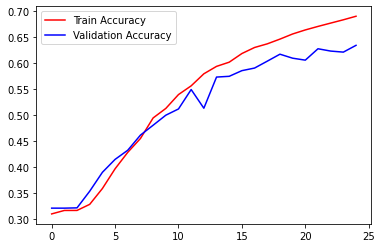

In [ ]:
# For generating the Plots of Training Acc and Validation Acc while Training the model

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(history.history['accuracy'],'r')
ax.plot(history.history['val_accuracy'],'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

In [ ]:
# Training the Teacher Student Model
import keras as K
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/Models/crnn.h5')
X_d_train,X_d_test,y_d_train,y_d_test = train_test_split(X_train,y_train,test_size = 0.2)
y_teacher = T.predict(X_test)
print(y_teacher)
y_train_student = np.concatenate((y_d_train,y_teacher)) 
X_train_student = np.concatenate((X_d_train,X_test))
S = melody_ResNet()
S.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
history1 = S.fit(X_train_student,y_train_student,batch_size=64,epochs=20,validation_data=(X_d_test,y_d_test))
print("New Model Saved")
S.save('/content/drive/MyDrive/ATML-project/teacher_student_new.h5')

In [ ]:
print(y_d_train)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


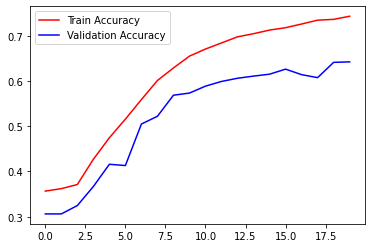

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(history1.history['accuracy'],'r')
ax.plot(history1.history['val_accuracy'],'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

In [ ]:
def Thres(a):
    if -0.5<a and a<0.5:
        t=1
    else:
        t=0
    return t

def VoiceRecall(v, pred_Melody):
    N=0
    D=0
    Nt = len(v)
    for i in range(Nt):
        if v[i]==1:
            D+=1
            if pred_Melody[i]!=0:
                N+=1
    if D==N:
        return 100
    VR=(N/D)*100
    return VR

def VoiceFalseAlarm(v, pred_Melody):
    N=0
    D=0
    Nt = len(v)
    for i in range(Nt):
        if v[i]==0:
            D+=1
            if pred_Melody[i]!=0:
                N+=1
    if D==N:
        return 100
    VFA=(N/D)*100
    return VFA

def Accuracy(v, pred_Melody, pitch_labels):
    N=0
    Nt = len(v)
    for i in range(Nt):
        if v[i]==1:
            if pred_Melody[i]!=0:
                N+=v[i]*Thres(pred_Melody[i]-pitch_labels[i])
        else:
            if pred_Melody[i]==0:
                N+=1
    accuracy=(N/Nt)*100
    return accuracy

In [ ]:
# For Evaluation
%pip install mir_eval
from mir_eval.melody import raw_pitch_accuracy, raw_chroma_accuracy, hz2cents

def predict_pitch(y_predict):
    y_shape = y_predict.shape
    num_total_frame = y_shape[0]*y_shape[1]
    est_pitch = np.zeros(num_total_frame)
    index_predict = np.zeros(num_total_frame)

    y_predict = np.reshape(y_predict, (num_total_frame, y_shape[2]))

    for i in range(num_total_frame):
        index_predict[i] = np.argmax(y_predict[i, :])
        est_pitch[i] = pitch_range[np.int32(index_predict[i])]
        
    return est_pitch

pitch_dir = '/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_labels'
wav_file = "/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav"

def evaluation_metrics(wav_file, pitch_dir, model):
  files = glob.glob(wav_file+'/*.wav')
  files.sort()
  total_rpa,total_rca,total_vfa,total_vr,total_oa = 0,0,0,0,0
  for i in range(len(files)):  
    print(files[i])
    time,y_true,x = spec_extraction(files[i], 31,test=True)
    x = np.reshape(x,(-1,31,513,1))
    ypred = model.predict(x)
    y_pred = librosa.midi_to_hz(predict_pitch(ypred))
    y_true = librosa.midi_to_hz(predict_pitch(y_true))
    ref_voicing = np.array([1 if i>0 else 0 for i in y_true])
    est_voicing = np.array([1 if i>0 else 0 for i in y_pred])

    y_true = hz2cents(y_true)
    y_pred = hz2cents(y_pred)
    
    rpa = raw_pitch_accuracy(ref_voicing,y_true,est_voicing,y_pred)
    rca = raw_chroma_accuracy(ref_voicing,y_true,est_voicing,y_pred)
    vfa = VoiceFalseAlarm(ref_voicing, y_pred)
    oa = Accuracy(ref_voicing,y_pred,y_true)
    vr = VoiceRecall(ref_voicing, y_pred)

    total_rpa+=rpa
    total_rca+=rca
    total_vfa+=vfa
    total_vr+=vr
    total_oa+=oa
    #print('RPA : ',rpa,'RCA : ',rca)
  print('Avg RPA : ',total_rpa/len(files))
  print('Avg RCA : ',total_rca/len(files))
  print('Avg VFA : ',total_vfa/len(files))
  print('Avg VR : ',total_vr/len(files))
  print('Avg OA : ',total_oa/len(files))
  

     |████████████████████████████████| 92kB 6.3MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=398c4dd659187b8b5693f9c6d3d9efdfa16f36d63bf4090f196684fc5a861db0
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [ ]:
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/Models/teacher_student_new.h5')
evaluation_metrics(wav_file,pitch_dir,T)

/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train01.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train02.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train03.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train04.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train05.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train06.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train07.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train08.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train09.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train10.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train11.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train12.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train13.wav
Avg RPA :  0.656756690164216
Avg RCA :  0.699294218290363
Avg VF

In [ ]:
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/Models/crnn.h5')
evaluation_metrics(wav_file,pitch_dir,T)

In [ ]:
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/ATML-project/ResNet_NS.hdf5')
evaluation_metrics(wav_file,pitch_dir,T)

/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train01.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train02.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train03.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train04.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train05.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train06.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train07.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train08.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train09.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train10.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train11.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train12.wav
/content/drive/MyDrive/ATML-project/MIR-1K/Mirex05_wavfiles/train13.wav
Avg RPA :  0.7684729655733779
Avg RCA :  0.7907108137808255
Avg 

In [ ]:
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/ATML-project/ResNet_NS.hdf5')
evaluation_metrics(wav_file,pitch_dir,T)

/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_fem2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_fem4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_male3.wav
/cont

In [ ]:
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/Models/crnn.h5')
evaluation_metrics(wav_file,pitch_dir,T)

/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_fem2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_fem4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_male3.wav
/cont

In [ ]:
T = melody_ResNet()
T.load_weights('/content/drive/MyDrive/Models/teacher_student_new.h5')
evaluation_metrics(wav_file,pitch_dir,T)

/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/daisy4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/jazz4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi1.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi3.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/midi4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_fem2.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_fem4.wav
/content/drive/MyDrive/ATML-project/MIR-1K/adc2004_wav/opera_male3.wav
/cont